In [1]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

In [5]:
generator = Sequential([
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, 5, 5, border_mode='same', activation='tanh')
    ])

In [6]:
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 6272)          633472      dense_input_1[0][0]              
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 6272)          25088       dense_1[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 7, 7, 128)     0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
upsampling2d_1 (UpSampling2D)    (None, 14, 14, 128)   0           reshape_1[0][0]                  
___________________________________________________________________________________________

In [7]:
discriminator = Sequential([
        Convolution2D(64, 5, 5, subsample=(2,2), input_shape=(28,28,1), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

In [8]:
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 14, 14, 64)    1664        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 14, 64)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 7, 7, 128)     204928      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 7, 7, 128)     0           convolution2d_4[0][0]            
___________________________________________________________________________________________

In [9]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [11]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 28, 28, 1)     865281      input_1[0][0]                    
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             212865      sequential_1[1][0]               
Total params: 1,078,146
Trainable params: 1,065,474
Non-trainable params: 12,672
____________________________________________________________________________________________________


In [13]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [14]:
train(30, 128)

100%|██████████| 468/468 [00:39<00:00, 11.75it/s]


In [17]:
generator.save_weights('gen_30_scaled_images.h5')
discriminator.save_weights('dis_30_scaled_images.h5')

In [18]:
train(20, 128)

100%|██████████| 468/468 [00:39<00:00, 11.73it/s]


In [21]:
generator.save_weights('gen_50_scaled_images.h5')
discriminator.save_weights('dis_50_scaled_images.h5')

In [14]:
generator.load_weights('gen_50_scaled_images.h5')
discriminator.load_weights('dis_50_scaled_images.h5')

In [35]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

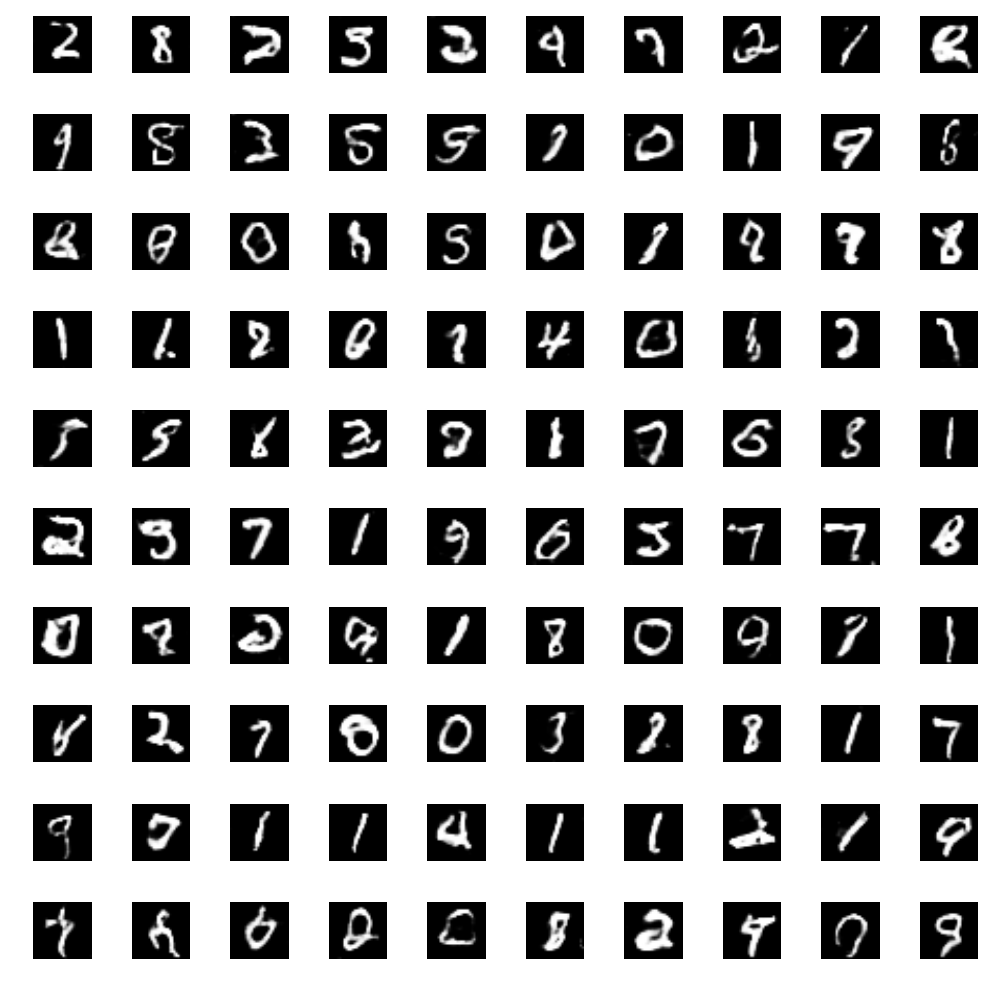

In [36]:
plot_output()